In [26]:
import torch
from model import SimpleModel, ModelCT
from torch.utils.data import DataLoader
from datareader import DataReader
import numpy as np
from utils import read_from_pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [33]:
main_path_to_data = "processed"

train_validation_info = read_from_pickle(main_path_to_data + "/train_info")

[train_info, valid_info] = train_test_split(train_validation_info, test_size=0.1, train_size=None, random_state=None, shuffle=True)
#train_info = np.genfromtxt(main_path_to_data + "/train_info")
print("Validation sample: %d\nTrain sample: %d \nTotal sample: %d" %(len(validation_info), len(train_info), len(train_validation_info)))

Validation sample: 28
Train sample: 244 
Total sample: 272


In [34]:
# DataLoader za ucno mnozico:
train_datareader = DataReader(main_path_to_data, train_info)
train_generator = DataLoader(train_datareader, batch_size=16, shuffle=True, pin_memory=True, num_workers=4)
#DataLoader za validacijsko mnozico
valid_datareader = DataReader(main_path_to_data, valid_info)
valid_generator = DataLoader(valid_datareader, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)

BCEWithLogitsLoss()

In [36]:
Model = SimpleModel()
Model.cpu()
#Model.cuda()

# Kriterijska funkcija
criterion_clf = torch.nn.BCEWithLogitsLoss()

# Izbira optimizatorja
optimizer = torch.optim.Adam(Model.parameters(), lr=1e-3, weight_decay=0.00001)

# Definicija urnika spreminjanja stopnje ucenja-> LR - LR*multipliktaro
multiplicator = 0.9
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, multiplicator, last_epoch=-1)

loss_history = []
aucs = []

n_epoch = 1
for epoch in range(100):
    print("\nEpoch:", n_epoch, end = ' ')
    n_epoch += 1
    Model.train() # nastavimo model v fazo ucenja

    n_batch = 1
    nall_batch = len(train_generator)
    print("batch %d:" %nall_batch, end =" ")

    for item_train in train_generator: # izberemo generiran batch
        # Propagacija naprej in izracun izgube
        optimizer.zero_grad()
        
        loss = Model.train_update(item_train, criterion_clf)
        loss_history.append(loss.item()) # save loss

        # Propagacija nazaj
        loss.backward()
        optimizer.step()

        print("%d (%0.1g)" %(n_batch, loss_history[-1]), end =" ")
        n_batch += 1

    # Validiramo, da vidimo kako kaze generalizacija
    #Model.eval()
    # Calculate AUC on validation set
    predictions = []
    trues = []
    for item_valid in valid_generator:
        prediction = Model.predict(item_valid, is_prob=True)
        predictions.append(np.mean(prediction.cpu().numpy()))
        trues.append(item_valid[1].numpy()[0])

    auc = roc_auc_score(trues, predictions)
    aucs.append(auc)
    print("auc: %0.2g" %auc)
    scheduler.step() # sprememba urnika za stopnjo ucenja vsak epoh
    torch.save(Model.state_dict(), 'LAST_model.pth') #shranimo model


Epoch: 1 batch 16: 1 (0.7) 2 (3e+01) 3 (5e+01) 4 (7e+01) 5 (2e+01) 6 (2e+01) 7 (3e+01) 8 (2e+01) 9 (1e+01) 10 (1) 11 (7) 12 (2e+01) 13 (5) 14 (0.7) 15 (1) 16 (8) 

NameError: name 'roc_auc_score' is not defined

In [9]:
loss.item()

3.359402894973755

(0, 500)

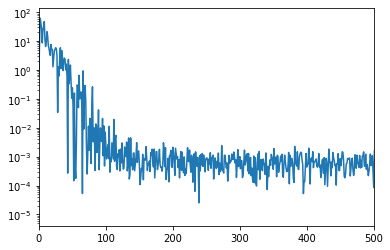

In [16]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.yscale('log')
plt.xlim([0, 500])